# 03 Evaluate fastText

#### Evaluér og fastslå hvor brugbar den valgte model er ved at sammenligne træningsdata- med valideringsdata.

In [20]:
import fasttext
import pandas as pd
import numpy as np

from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

### Functions

In [21]:
# Funktion til at splitte et datasæt op til hhv. train og validation
def split_csv_file(file, weight):
    csv = pd.read_csv('./data/' + file + '.csv')

    train, valid = np.split(csv.sample(frac=1), [int(weight*len(csv))])
    
    np.savetxt('./data/'+file+'.train', train, header='rating,review', comments='', delimiter=',', fmt='%s')
    np.savetxt('./data/'+file+'.valid', valid, header='rating,review', comments='', delimiter=',', fmt='%s')

In [22]:
# Funktion til at omregne til procent
def to_perc(a, b, c = 0):
    if (a > 0) and (b > 0):
        c = a / (a+b) * 100
    return c

In [34]:
# Funktion til at finde den mest optimale epoch iteration af datasættet
def model_trainer():
    data_train = './data/' + file + '.train'
    data_valid = './data/' + file + '.valid'
    models_train = [(0,0,0)]
    models_valid = [(0,0,0)]
    peak_epoch = 0
    peak_value = 0.0

    with tqdm(total=epoch+1) as progress:
        for i in range(epoch+1):
            progress.update(1)

            model = fasttext.train_supervised(input=data_train, epoch=i, lr=lr, wordNgrams=wordNgrams, bucket=bucket, dim=dim, loss=loss)

            models_train.append(model.test(data_train, k=top_labels))
            models_valid.append(model.test(data_valid, k=top_labels))

            if (len(models_train) == 3):
                print('             Training  |    Validation')
                print('        ', '{0:6}'.format(models_train[i][0]), '{:.1f}'.format(to_perc(models_train[i][0], models_valid[i][0])) + '%',
                      ' | ', '{0:6}'.format(models_valid[i][0]), '{:.1f}'.format(to_perc(models_valid[i][0], models_train[i][0])) + '%')
                print('                       |')
                print('Epoch   ', 'Prec.', 'Recall  | ', 'Prec.', 'Recall')
                print('-----------------------+---------------------------')
            
            if (models_valid[i][1] > peak_value):
                peak_value = models_valid[i][1]
                peak_epoch = i
                peak_model = model
                precision = '\033[92mHigher\033[0m'
            else:
                precision = '\033[91mLower\033[0m'
            
            if (len(models_train) > 2):
                print('{0:2}'.format(i), ' ==> ', '{:.3f}'.format(models_train[i][1]), ' {:.3f}'.format(models_train[i][2]),
                      ' |', ' {:.3f}'.format(models_valid[i][1]), ' {:.3f}'.format(models_valid[i][2]), ' ==> ', precision)

        print('\n    -->  Epoch peaked at', '\033[1m' + '\033[94m' + str(peak_epoch))

        #model.save_model('./data/fasttext_trained_model.bin')
        
        return peak_epoch, models_train, models_valid

In [35]:
# Visualisér modellen via plotting
def model_plot(title, i, peak_epoch, models_train, models_valid):
    threshold = 0.2
    y_range_min = min([y[i] for y in models_valid if y[i] > threshold])
    y_range_max = max([y[i] for y in models_train if y[i] > threshold])
    
    plt.plot([pr[i] for pr in models_train], label='Training')
    plt.plot([pr[i] for pr in models_valid], label='Validation')
    plt.axvline(peak_epoch, linewidth=2, color='g', linestyle='--', label=('Epoch Peak'))
    
    peak_value = models_valid[peak_epoch][i]
    
    plt.annotate('{:.3f}'.format(peak_value),
                 xy=(peak_epoch,peak_value),
                 xytext=(peak_epoch-3, peak_value+0.01),
                 arrowprops={'arrowstyle' : 'simple', 'shrinkB' : 5, 'color' : 'black'},
                 color='black')
    
    plt.title('Model (' + title + ')')
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(loc='upper left')
    plt.ylim([y_range_min, y_range_max+0.01])
    
    return plt.show()

### Execute

             Training  |    Validation
         210187 80.0%  |   52547 20.0%
                       |
Epoch    Prec. Recall  |  Prec. Recall
-----------------------+---------------------------
 1  ==>  0.058  0.115  |  0.057  0.115  ==>  Higher
 2  ==>  0.453  0.906  |  0.449  0.898  ==>  Higher
 3  ==>  0.462  0.923  |  0.454  0.907  ==>  Higher
 4  ==>  0.467  0.934  |  0.454  0.909  ==>  Higher
 5  ==>  0.472  0.944  |  0.455  0.909  ==>  Higher
 6  ==>  0.476  0.951  |  0.453  0.907  ==>  Lower
 7  ==>  0.479  0.958  |  0.452  0.903  ==>  Lower
 8  ==>  0.481  0.962  |  0.451  0.902  ==>  Lower
 9  ==>  0.484  0.968  |  0.449  0.899  ==>  Lower
10  ==>  0.486  0.971  |  0.448  0.897  ==>  Lower

    -->  Epoch peaked at 5



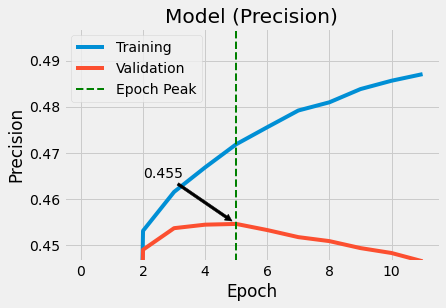

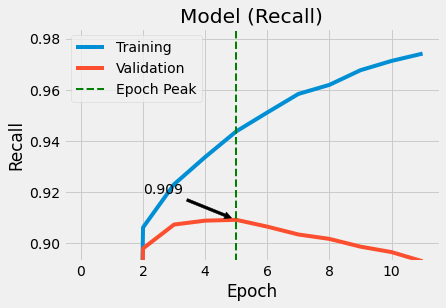

In [36]:
file = 'combined_csv'

# Split csv filen i hhv. trænings- og valideringsdata
weight     = 0.8
split_csv_file(file, weight)

# Træn modellen ud fra givne parameter
epoch      = 10
lr         = 0.2
wordNgrams = 2
bucket     = 20000
dim        = 200
loss       = 'ova'
top_labels = 2

mt = model_trainer()

# Plot modellen
model_plot('Precision', 1, mt[0], mt[1], mt[2])
model_plot('Recall', 2, mt[0], mt[1], mt[2])